<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_RS_gr2/blob/Kostin-Sergey-folder/ProfPotol.AI_Summary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Важное**

Вплоть до "Обзор полученных результатов. Первые выводы" доволно скучно и рутинно.

Рекомендую ознакомиться с общими описаниями разделов, не углубляясь в их содержимое.

# Глобальные настройки

---



In [1]:
# Включён ли режим отладки
DEBUG = False
SAVE_TEMP_DF = False

# Маска, применяемая для проверки Guid-строк
GUID_MASK = 'XXXXXXXX-XXXX-XXXX-XXXX-XXXXXXXXXXXX'

In [2]:
### Прописанные пути

# Путь к корневой папке Drive
DRIVE_PATH = '/content/drive/MyDrive/UAI_Courses/Stage1/'
# Путь к промежуточной папке
DRIVE_LOCAL = 'Attempt2/'

# Использовать ли Drive для загрузки оригинального датасета (ускоряет работу; требуется доступ к Drive и сохранённый ДС)
USE_DRIVE = True

# Ссылка и имя файла для загрузки с сервера
DATA_SERVER_PATH = 'https://storage.yandexcloud.net/terratraineeship/23_InspectrumClinic_RS/datasets/'
DATA_FILENAME = '%D0%B4%D0%B0%D1%82%D0%B0%D1%81%D0%B5%D1%82%20%D0%BF%D1%80%D0%BE%D1%84%D0%BF%D0%B0%D1%82%D0%BE%D0%BB%D0%BE%D0%B3%20%D1%87%D0%B0%D1%81%D1%82%D1%8C.xlsx'

In [3]:
# Текущий режим работы алгоритма
MODE = 0

# Названия режимов работы
MODES = {
    0 : 'DataSet1',
    1 : 'DataGlobalClear_1.Prototype',
    2 : 'DataGlobalClear_2.ClearPrototype',
    3 : 'DataGlobalClear_3.ClearSet',
    4 : 'DataGlobalClear_4.ClearSet2',
    5 : 'Global_FinalSplittedSet_',
}

# Файл, связанный с текущим режимом работы
DRIVE_NAME = MODES[MODE] + '.xlsx'

PATH_DATA = {
    0 : DRIVE_PATH + MODES[0] + '.xlsx',
    1 : DRIVE_PATH + DRIVE_LOCAL + MODES[1] + '.xlsx',
    2 : DRIVE_PATH + DRIVE_LOCAL + MODES[2] + '.xlsx',
    3 : DRIVE_PATH + DRIVE_LOCAL + MODES[3] + '.xlsx',
    4 : DRIVE_PATH + DRIVE_LOCAL + MODES[4] + '.xlsx',
    5 : DRIVE_PATH + DRIVE_LOCAL + MODES[5] + '.xlsx',
}

In [4]:
# Строки, содержащие аномалии
# (вместо хардкода можно прописать алгоритм по проверке значения, хранящегося в МКБ с необходимым сдвигом)
ANOMALIES = [ 843, 851, 1022, 1024 ]

# Сборка


---


Подключение внешних библиотек и кастомных методов, необходимых для работы программы.

1. `bool is_guid(text)`

  Функция проверки входного объекта на строку типа GUID

2. `bool are_together(text1, text2)`
  
  Проверяет, если два заголовка столбцов отностяся к одной категории медосмотра типа "Хирург1_..."

3. `DataFrame get_total(temp, mask)`

  Накладывает индексную маску на исходный df

4. `list get_normal(mean, count, stddev, min = 0, max = 100, include = False)`

  Создаёт массив по Гауссу с модой mean, кол-ом count, отклонение stddev, находящей в пределах { include ? [min, max] : (min, max) }

5. `list double_series(n, x, num_terms, b = 2)`
  
  Создаёт ряд от начального числа n, где каждое следующее число выражено формулой:
  n(i+1) = n(i) + x/b^i

## **Подключение библиотек**

Подключение библиотек и модулей, необходимых для работы

In [5]:
# gdown for data access
import gdown

# Pandas for data manage
import pandas as pd

# NumPy for data transform
import numpy as np

# Tensorflow for arrays
import tensorflow as tf

# Подключение графиков
import matplotlib.pyplot as plt
%matplotlib inline

## **Объявление функций**

Инициализация кастомных функций, необходимых для работы

In [6]:
# Функция проверки входного объекта на строку типа GUID
# Возврат: bool
def is_guid(text):
  if not isinstance(text, str): return False
  if len(text) != len(GUID_MASK): return False

  rbt = ''
  for lt in text:
    if lt.isdigit() or lt.isalpha(): rbt += 'X'
    else: rbt += lt
  return rbt == GUID_MASK

In [7]:
# Проверяет, если два заголовка столбцов отностяся к одной категории типа "Хируриг1_..."
# Возврат: bool
def are_together(text1, text2):
  if DEBUG:
    print(text1, text2, '_' in text1, '_' in text2)

  if not '_' in text1: return False #not '_' in text2
  return text1[:text1.index('_')] == text2[:text2.index('_')]

In [8]:
# Накладывает индексную маску на исходный df
# Возврат: DataFrame
def get_total(temp, mask):
  return temp.iloc[:, mask]

In [9]:
# Создаёт массив по Гауссу с модой mean, кол-ом count, отклонение stddev,
# находящей в пределах { include ? [min, max] : (min, max) }
# Возврат: list()
def get_normal(mean, count, stddev, min = 0, max = 100, include = False):
  array = tf.random.normal(shape=[count], mean=mean, stddev=stddev)
  array = array.numpy()

  # Преобразование значений, превышающих max
  for i in range(len(array)):
    if include:
      if array[i] < min:
          array[i] = min + (min - array[i])
      if array[i] > max:
          array[i] = max - (array[i] - max)
    else:
      if array[i] <= min:
          array[i] = min + (min - array[i])
      if array[i] >= max:
          array[i] = max - (array[i] - max)

  # Сортировка итогового массива по возрастанию
  return np.sort(array).tolist()

In [10]:
# Создаёт ряд от начального числа n, где каждое следующее число выражено формулой:
#   n(i+1) = n(i) + x/2^i
# Возврат: list()
def double_series(n, x, num_terms, b = 2):
    series = [n]
    for i in range(num_terms - 1):
        next_term = series[-1] + x / b**i
        series.append(next_term)
    return series

# Инициализация (#source)

---

Загружает и распаковывает данные. На выходе имеем:
1. `DataFrame source` - исходный объём данных
2. `int height = data.shape[0]`
3. `int width = data.shape[1]`

## **Загрузка данных**

Загружает данные с Сервера/Drive в зависимости от USE_DRIVE

Полученные данные доступны через: source (DataFrame)

In [11]:
sourceFile = PATH_DATA[MODE]
if not (USE_DRIVE):
  gdown.download(DATA_SERVER_PATH + DATA_FILENAME, None, quiet=True)
  sourceFile = DATA_FILENAME

In [12]:
source = pd.read_excel(sourceFile)
data = source.copy()
height = data.shape[0]
width = data.shape[1]

# Подготовка данных


---


**Общий ДС (`source`)** - штука тяжёлая и загружается долго. При этом каждый раз одни и те же манипуаляции необходимо проделывать с сырым ДС. Для упрощении работы с фреймом делается следующее:

**Прототип (`df_prototype`)** - буквально прототип ДС. В нём содержатся:
1. Индекс столбца
2. % пропусков по данному столбцу
3. Первые "prev = 3" not-Nan образцов данных

**Чистый сет (`df_clear`)** - очищенный ДС. В понятие очистки входят:
1. Удаление GUID
2. Удаление времени
3. Удаление дубликатов Представлений
4. Применение ручных required/forbidden
5. Удаление почти пустых столбцов (>99%)

**Гендерные сеты (`df_male` / `df_demale`)** - мужской и женский датасеты.

## **Прототип (\#df_prototype)**

### Создание прототипа. Выгрзука столбцов.
Созданние прототипа базы данных: % nan + образцы данных

In [13]:
if (MODE != 0):
  raise Exception("Not Source Mode")

In [14]:
df_prototype = pd.DataFrame()

for i in range(data.shape[1]):
  cname = data.columns[i]
  prev = 3
  perc = [ i, data[cname].isna().mean() * 100 ]
  nval = data[cname].dropna().head(prev).tolist()
  for i in range(prev - len(nval)):
    nval.append(np.NaN)
  df_prototype.insert(loc=len(df_prototype.columns), column=cname, value=perc+nval)

Выходные данные были обрезаны до нескольких последних строк (5000).
<ipython-input-14-fb9fb79e190b>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_prototype.insert(loc=len(df_prototype.columns), column=cname, value=perc+nval)
<ipython-input-14-fb9fb79e190b>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_prototype.insert(loc=len(df_prototype.columns), column=cname, value=perc+nval)
<ipython-input-14-fb9fb79e190b>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.inse

In [15]:
data = df_prototype

MODE += 1
height = data.shape[0]
width = data.shape[1]
if SAVE_TEMP_DF:
  data.to_excel(PATH_DATA[MODE], index=False)

## **Чистый датасет (\#df_clear)**

### Параметры

Объявление переменных и параметров, необходимых для работы внутренних алгоритмов.

In [16]:
if DEBUG:
  pd.set_option('display.max_columns', None)
  #pd.reset_option('display.max_columns')
  data.iloc[0:10, 0:25].head()
  res = []
  for i in range(data.shape[1]):
    col = data.columns[i]
    if 'мкб10' in col.lower():
      res.append(i)
  print(len(res))
  res
  get_total(df_prototype, res).to_excel(DRIVE_PATH + DRIVE_LOCAL + 'МКБ10.xlsx', index=False)

In [17]:
required = [
    'КлиентДатаРождения',
    'КлиентПолПредставление',
    'Профессия',
    'ВредныеФакторы',
    'ЗаключениеМКПредставление',
    'ДиспансернаяГруппа',

    #'Представления',
]
required = list(map(lambda x: x.lower(), required))

In [18]:
forbidden = [
    'Заключение',
    'ЗаключениеМК',

    'Цех',
    'СалонПредставление',
    'СпециализацияПредставление',
    'Врач_ЗначениеПредставление',
    'ВрачФио_ЗначениеПредставление',
    'Рекомендация',
    'Заключение_ЗначениеПредставление',
    '_Профессиональное1',
    'ПрофнепригодностьВременная1',

    'ДатаЗавершенияМедосмотра',
    'ТипМедосмотраПредставление',
    'ЛабораторныеИсследования1_'
]
forbidden = list(map(lambda x: x.lower(), forbidden))

### Общая очистка

Общее чистка данных:
1. Удаление GUID
2. Удаление времени
3. Удаление дубликатов Представлений
4. Применение ручных required/forbidden
5. Удаление почти пустых столбцов (>99%)

In [19]:
if (MODE != 1):
  raise Exception("Not Proto Mode")

In [20]:
saved = []
MKBs = []

for i in range(width):
  cname = data.columns[i].lower()

  # Сохранение необходимых колонок
  if (cname in required):
    saved.append(i)
    continue

  # Сохранение МКБ
  if ('МКБ10'.lower() in cname):
    MKBs.append(cname)
    saved.append(i)
    continue

  # Удаление лишних столбцов
  valid = True
  for f in forbidden:
    if (f in cname):
      valid = False
      break
  if not valid: continue

  # Удаление безнадёжно пустых колонок
  nval = data.iloc[1, i]
  if (nval > 99):
    continue

  # Чистка по сэмплу данных
  sample = data.iloc[2, i]
  if (is_guid(sample)):
    continue
  if (data.dtypes.iloc[i] == np.dtype('datetime64[ns]') or 'ДатаПриема'.lower() in cname):
    continue
  if (i < width - 1 and (cname + 'Представление').lower() == str(data.columns[i + 1]).lower()):
    continue

  saved.append(i)

In [21]:
data = get_total(data, saved)

MODE += 1
height = data.shape[0]
width = data.shape[1]
if SAVE_TEMP_DF:
  data.to_excel(PATH_DATA[MODE], index=False)

### Сброка чистого датасета по пртотипу

Очищенный прототип df_prototype содержит в себе очищенные колонки. Поскольку после чистки их индексы перепутаны, df_prototype в первой строке хранит оригинальное значение индекса колонки.

По этому принципу собирается маска для получения df_clear из source.

In [22]:
if (MODE != 2):
  raise Exception("Not Clearing Mode")

In [23]:
mask = data.iloc[0, :].to_list()

In [24]:
df_clear = get_total(source, mask)
data = df_clear.copy()

MODE += 1
height = data.shape[0]
width = data.shape[1]
if SAVE_TEMP_DF:
  data.to_excel(PATH_DATA[MODE], index=False)

### Удаление аномалий

На основе гиперпараметра **ANOMALIES = [ ... ]**

In [25]:
if (MODE != 3):
  raise Exception("Not Anomaly Mode")

In [26]:
data.drop(ANOMALIES, inplace = True)
data.shape

(1978, 957)

### Удаление бесполезных строк
Удаляет все строки, которые не содержат данные в любом из необходимых столбцов параметра **\*required**

In [27]:
print(required)

reqId = []
for i in range(width):
  cname = data.columns[i].lower()
  if (cname in required):# or cname in MKBs):
    reqId.append(i)

print(data.shape)
data.dropna(subset=data.columns[reqId], inplace=True)
data.shape

['клиентдатарождения', 'клиентполпредставление', 'профессия', 'вредныефакторы', 'заключениемкпредставление', 'диспансернаягруппа']
(1978, 957)


(1562, 957)

In [28]:
MODE += 1
height = data.shape[0]
width = data.shape[1]
data.to_excel(PATH_DATA[MODE], index=False)

## **М/Ж Сплит (\#df_male + \#df_female)**

В первую очередь производится разбиение представлений данных по полу: на мужчин и женщин. Это есть необходимость и данность, как миниму потому, что у представителей мужского пола отсутсвует Гинеколог

In [29]:
MODE = 4

In [30]:
if (MODE != 4):
  raise Exception("Not M/F split Mode")

In [31]:
df_male = data[data['КлиентПолПредставление'] == 'Мужской']
df_female = data[data['КлиентПолПредставление'] == 'Женский']

In [32]:
MODE += 1
if SAVE_TEMP_DF:
  df_male.to_excel(DRIVE_PATH + DRIVE_LOCAL + MODES[5] + 'Male' + '.xlsx', index=False)

In [33]:
if SAVE_TEMP_DF:
  df_female.to_excel(DRIVE_PATH + DRIVE_LOCAL + MODES[5] + 'Female' + '.xlsx', index=False)

# Циклическая сборка данных


---



Данный модуль всецело посвещён мульти обработке данных

Производится оптимизация оставшихся данных по гендерам: проверяются различные соотношения заполненности колонок/столбцов.

**Выходным результатом** работы модуля является:

- `list() ds_to_explore` - массив с результатами работы модуля

Структура массива: (`df_\*`, `ds_to_explore_\*`, `skip_\*`)
- `DataFrame df_\*` - исходный датасет, который обрабатывался с данными правилами. На данный момент это два гендерных ДС: male\female.
- `list() ds_to_explore_\*` - массив обработанных и почищенных ДС, доступных для дальнейшего исследования.
- `list() skip_\*` - массив обработанных и почищенных ДС, недоступных для дальнейшего исследования (пропущенных).

Объекты данных `ds_to_explore_\*` и `skip_\*` являются словарём со следующими ключами:
- `lossLimit_Key = 'lslmt'` - Параметр потери данных, применённый при чистке
- `MKBsLimit_Key = 'MKBslmt'` - Параметр потери МКБ, применённый при чистке
- `data_Key = 'data'` - Новый датафрейм, результат чистки
- `dataCols_Key = 'svcols'` - Колонки, содержащиеся в данном датафрейме

## **Настройка параметров модуля**

In [64]:
# Сохранённые для дальнейшего исследования мужские датафреймы
ds_to_explore_male = []
# Сохранённые для дальнейшего исследования женские датафреймы
ds_to_explore_female = []
# Пропущенные мужские датафреймы
skip_male = []
# Пропущенные женские датафреймы
skip_female = []

# > Для каждого отношения потерь данных/МКБ создаётся словарь с параметрами, доступными по этим ключам
# Параметр потери данных
lossLimit_Key = 'lslmt'
# Параметр потери МКБ
MKBsLimit_Key = 'MKBslmt'
# Новый датафрейм
data_Key = 'data'
# Колонки, содержащиеся в данном датафрейме
dataCols_Key = 'svcols'

In [65]:
# Параметры дропа при уровне потерь

# > Обработка мужское/женское
lossLimitValues = double_series(10, 11, 15, 1.1)
lossLimitValues.reverse()
print(lossLimitValues)

# > Исследование МКБ10
MKBsLimitValues = tf.range(20, 86, 5).numpy().tolist()
MKBsLimitValues.reverse()
print(MKBsLimitValues)

[99.13691822896428, 95.9506100518607, 92.44567105704678, 88.59023816275146, 84.34926197902662, 79.6841881769293, 74.55260699462224, 68.90786769408447, 62.69865446349293, 55.86851990984222, 48.35537190082645, 40.09090909090909, 31.0, 21.0, 10]
[85, 80, 75, 70, 65, 60, 55, 50, 45, 40, 35, 30, 25, 20]


In [66]:
# Наборы датасетов, сформированных для дальнейшего исследования
ds_to_explore = [
    (df_male, ds_to_explore_male, skip_male),
     (df_female, ds_to_explore_female, skip_female)
     ]

## **Обработка мужское/женское**

`list() Explore_DataLoss(df, lossLimit)`

*return: mask with columns to save*

Может показаться, что переменная loss для любого значения будет <=99, так как подобная чистка уже проводилась в рамках df\_clear с помощью df\_prototype, однако в том методе имело место жёсткое сохранение некоторых столбцов типа \*required и "\*Представление"

В данном же случае упор делается по большей части именно на колонки типа "\*Представление", содержащие немалое кол-во пустых, невалидных данных.

**Приемлимое число допустимых потерь релизуется гиперпараметром `lossLimit`**

In [67]:
def Explore_DataLoss(df, lossLimit):
  res = []

  if DEBUG:
    print('DataLoss / ', lossLimit)

  for i in range(df.shape[1]):
    cname = df.columns[i]
    loss = df[cname].isna().mean() * 100

    # ! lossLimit
    if loss < lossLimit or 'мкб10' in cname.lower():
      res.append(i)
    elif DEBUG:
      print('skip col: ', cname, round(loss, 2))
  return res

## **Исследование МКБ10**

`list() Explore_MKB(df, MKBsLimit)`

*return: mask with columns to save*

Уже на этом этапе трабл - если сохранять все назначения МКБ, то данных не остаётся вообще

На данном этапе производится очистка датасета от незаполненных МКБ колонок.

**Проверка заполненности осуществляется посредством гиперпараметра `MKBsLimit`**



In [68]:
def Explore_MKB(df, MKBsLimit):
  # Индексы колонок, которые надо сохранить
  cols_to_save = []
  # Сохранённые МКБ колонки, чтобы глазами просмотреть. Скорее больше DEBUG
  mkb_Review = []
  # Коллектор всех МКБ колонок. Разница с ^Review - удалённые МКБ.
  mkb_Collector = []

  if DEBUG:
    print('МКБ / ', MKBsLimit)

  for i in range(df.shape[1]):
    cname = df.columns[i]
    loss = df[cname].isna().mean() * 100

    if 'мкб10' in cname.lower():
      mkb_Collector.append(cname.lower())

    # ! MKBsLimit
      if loss < MKBsLimit:
        cols_to_save.append(i)
        mkb_Review.append((cname, loss))
      elif DEBUG:
        print('skip col: ', cname, round(loss, 2))

    else: #if loss < MKBsLimit:
      cols_to_save.append(i)

  # 7 - 209
  if DEBUG:
    print('МКБ ({0}%)\t- Всего: {1};\tМКБ-всего: {2};\tМКБ-осталось: {3}'.format(MKBsLimit, len(cols_to_save), len(mkb_Collector), len(mkb_Review)))

  return (cols_to_save, mkb_Collector, mkb_Review)

## **Непосредственная обработка**

In [69]:
# 452 209
for dfs in ds_to_explore:
  masks_Collector = []
  df_loss_temp = dfs[0].copy()
  for lossLimit in lossLimitValues:
    for MKBsLimit in MKBsLimitValues:
      if True:
        print(round(lossLimit), round(MKBsLimit), end = '\t')

      mask = Explore_DataLoss(df_loss_temp, lossLimit)
      df_loss_temp = get_total(df_loss_temp, mask)
      mask = Explore_MKB(df_loss_temp, MKBsLimit)[0]
      df_temp = get_total(df_loss_temp, mask)

      if (mask in masks_Collector):
        print('> skip', end = ' ')
        if DEBUG:
          print('(duplicate)', end = ' ')
        print()
        continue

      tmp_drop = df_temp.copy().dropna()

      tmp = dict()
      tmp[data_Key] = tmp_drop
      tmp[dataCols_Key] = mask
      tmp[lossLimit_Key] = lossLimit
      tmp[MKBsLimit_Key] = MKBsLimit

      fillness = tmp_drop.shape[0] / df_loss_temp.shape[0]
      if (fillness < 0.3):
        print('> skip', end = ' ')
        if DEBUG:
          print('(low fillness: {0}%)'.format(round(fillness * 100, 2)), end = ' ')
        print()
        dfs[2].append(tmp)
      else:
        print('>save ({0} -> {1})'.format(df_temp.shape, tmp_drop.shape))
        masks_Collector.append(mask)
        dfs[1].append(tmp)
  print()

99 85	> skip 
99 80	> skip 
99 75	> skip 
99 70	> skip 
99 65	> skip 
99 60	> skip 
99 55	> skip 
99 50	> skip 
99 45	> skip 
99 40	> skip 
99 35	> skip 
99 30	> skip 
99 25	> skip 
99 20	> skip 
96 85	> skip 
96 80	> skip 
96 75	> skip 
96 70	> skip 
96 65	> skip 
96 60	> skip 
96 55	> skip 
96 50	> skip 
96 45	> skip 
96 40	> skip 
96 35	> skip 
96 30	> skip 
96 25	> skip 
96 20	> skip 
92 85	> skip 
92 80	> skip 
92 75	> skip 
92 70	> skip 
92 65	> skip 
92 60	> skip 
92 55	> skip 
92 50	> skip 
92 45	> skip 
92 40	> skip 
92 35	> skip 
92 30	> skip 
92 25	> skip 
92 20	> skip 
89 85	> skip 
89 80	> skip 
89 75	> skip 
89 70	> skip 
89 65	> skip 
89 60	> skip 
89 55	> skip 
89 50	> skip 
89 45	> skip 
89 40	> skip 
89 35	> skip 
89 30	> skip 
89 25	> skip 
89 20	> skip 
84 85	> skip 
84 80	> skip 
84 75	> skip 
84 70	> skip 
84 65	> skip 
84 60	> skip 
84 55	> skip 
84 50	> skip 
84 45	> skip 
84 40	> skip 
84 35	> skip 
84 30	> skip 
84 25	> skip 
84 20	> skip 
80 85	> skip 
80 80	

# **Обзор полученных результатов. Первые выводы**

---

В данном разделе исследуются датасеты, полученные в серии предыдущих экспериментов по параметрам `lossLimit` и `MKBsLimit`, а также по значениям параметров ГОДЕН/НЕ ГОДЕН.

Делаются первые значительные выводы о непригодности исхоодного датасета.

## **Исследование оптимизации соотношения**
На основе параметров потерь данных `lossLimit` и потерь данных МКБ `MKBsLimit`

In [75]:
def exploreReqs(temp, reqs):
  finder = []
  for i in range(temp.shape[1]):
    if (temp.columns[i].lower() in reqs):
      finder.append(temp.columns[i].lower())
  return np.setdiff1d(reqs, finder)

In [76]:
for dfs in ds_to_explore:
  print('los | MKB |\tshape\t\t|\treq\t|\tmkb\t|')
  print(':' * 65)
  for part in dfs[1]:
    df_temp = part[data_Key]
    lossLimit = part[lossLimit_Key]
    MKBsLimit = part[MKBsLimit_Key]

    required_Loss = len(exploreReqs(df_temp, required))
    reqLsDisplay = '{0}/{1}'.format(len(required) - required_Loss, len(required))
    mkb_Loss = len(exploreReqs(df_temp, MKBs))
    mkbLsDisplay = '{0}/{1}'.format(len(MKBs) - mkb_Loss, len(MKBs))

    print('{0}% | {1}% |\t{2}\t|\t{3}\t|\t{4}\t|'.format(round(lossLimit), round(MKBsLimit), df_temp.shape, reqLsDisplay, mkbLsDisplay))
  print('\n')

los | MKB |	shape		|	req	|	mkb	|
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
40% | 40% |	(350, 156)	|	6/6	|	5/92	|
40% | 25% |	(350, 155)	|	6/6	|	4/92	|
40% | 20% |	(350, 154)	|	6/6	|	3/92	|
31% | 45% |	(338, 155)	|	6/6	|	6/92	|
31% | 40% |	(455, 154)	|	6/6	|	5/92	|
31% | 25% |	(455, 153)	|	6/6	|	4/92	|
31% | 20% |	(455, 152)	|	6/6	|	3/92	|
21% | 45% |	(364, 101)	|	6/6	|	6/92	|
21% | 40% |	(489, 100)	|	6/6	|	5/92	|
21% | 25% |	(620, 99)	|	6/6	|	4/92	|
21% | 20% |	(693, 98)	|	6/6	|	3/92	|
10% | 45% |	(425, 14)	|	6/6	|	6/92	|
10% | 40% |	(565, 13)	|	6/6	|	5/92	|
10% | 25% |	(717, 12)	|	6/6	|	4/92	|
10% | 20% |	(812, 11)	|	6/6	|	3/92	|


los | MKB |	shape		|	req	|	mkb	|
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
21% | 40% |	(155, 123)	|	6/6	|	6/92	|
21% | 30% |	(184, 122)	|	6/6	|	5/92	|
21% | 25% |	(238, 121)	|	6/6	|	4/92	|
21% | 20% |	(308, 120)	|	6/6	|	3/92	|
10% | 40% |	(163, 88)	|	6/6	|	6/92	|
10% | 30% |	(192, 87)	|	6/6	|	5/92	|
10% | 25% 

## **Промежуточные выводы**

1. Максимальная заполненность мужчин (73%) достигается при 11 столбцах

  Максимальная заполненность женщин (71%) достигается при 85 столбцах

  Это говорит о том, что женский датасет, в целом, заполнее больше и корректнее, чем мужской - средний столбец женского ДС содержит меньше пропусков, чем средний столбец мужского ДС.

2. Все столбцы, необходимых к сохранению из гиперпараметра `list() required` действительно были сохранены и не потерялись в процессе обработки

3. Большая часть столбцов МКБ удалена ввиду того, что не содержит валидных данных. Даже столбцов МКБ, заполненных на 65% - всего 6 штук.

4. Эффективность сохранения столбцов крайне мала ввиду их пустоты. Если сравнить данные следующих выборок при 40% потерь МКБ:
  1. 40% | 40% | (350, 156)
  2. 31% | 40% | (455, 154)
  3. 21% | 40% | (489, 100)
  4. 10% | 40% | (565, 13)

  И данные при заданной потери столбца =21% при переменном параметре потери МКБ:
  1. 21% | 45% | (364, 101)
  2. 21% | 40% | (489, 100)
  3. 21% | 25% | (620, 99)
  4. 21% | 20% | (693, 98)

  Можно заметить, что при увеличения пропускного лимита МКБ количество столбцов практически не изменяется, в то время как количество записей, доступных для обучения нейросети, резко падает.

  > **Из этого можно сделать вывод, что заполненность МКБ, имеющих прямое логическое влияние на качество нейросети, крайне скудна, что является первым подтверждением невалидного датасета.**

## **Исследование валидности 'ЗаключениеМКПредставление'**

In [77]:
diagnose_refs = {
    'Годен к работе в указанных условиях' : 'Годен',
    'Годен к работе в указанных условиях (с коррекцией зрения)' : 'Годен',
    'Годен к работе в указанных условиях (без работ на высотах)' : 'Годен',
    'Ограниченно годен' : 'Годен',
    'Временно не годен' : 'Не год.',
    'Нуждается в дообследовании и лечении' : '<(?)>',
    }

In [78]:
def get_DiagnoseRewiewString(temp, d_refs):
  refs_temp = dict()

  for val in d_refs:
    refs_temp[d_refs[val]] = 0

  unique_values = temp['ЗаключениеМКПредставление'].value_counts()
  for value, count in unique_values.items():
    refs_temp[d_refs[value]] += count

  printable = ''
  for val in refs_temp:
    printable += '\t{0}\t|'.format(refs_temp[val])
  return printable

In [79]:
# df_temp = dfs[0]

# Вывести данные об обработанных
for dfs in ds_to_explore:
  printable = 'los | MKB |\tshape\t\t|'
  printable += get_DiagnoseRewiewString(dfs[0], diagnose_refs)
  print(printable)
  print(':' * 81)
  for part in dfs[1]:
    df_temp = part[data_Key]
    lossLimit = part[lossLimit_Key]
    MKBsLimit = part[MKBsLimit_Key]

    printable = '{0}% | {1}% |\t{2}\t|'.format(round(lossLimit), round(MKBsLimit), df_temp.shape)
    printable += get_DiagnoseRewiewString(df_temp, diagnose_refs)

    print(printable)
  print('\n')

los | MKB |	shape		|	1102	|	7	|	1	|
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
40% | 40% |	(350, 156)	|	344	|	5	|	1	|
40% | 25% |	(350, 155)	|	344	|	5	|	1	|
40% | 20% |	(350, 154)	|	344	|	5	|	1	|
31% | 45% |	(338, 155)	|	332	|	5	|	1	|
31% | 40% |	(455, 154)	|	449	|	5	|	1	|
31% | 25% |	(455, 153)	|	449	|	5	|	1	|
31% | 20% |	(455, 152)	|	449	|	5	|	1	|
21% | 45% |	(364, 101)	|	358	|	5	|	1	|
21% | 40% |	(489, 100)	|	483	|	5	|	1	|
21% | 25% |	(620, 99)	|	614	|	5	|	1	|
21% | 20% |	(693, 98)	|	687	|	5	|	1	|
10% | 45% |	(425, 14)	|	418	|	6	|	1	|
10% | 40% |	(565, 13)	|	558	|	6	|	1	|
10% | 25% |	(717, 12)	|	710	|	6	|	1	|
10% | 20% |	(812, 11)	|	804	|	7	|	1	|


los | MKB |	shape		|	452	|	0	|	0	|
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
21% | 40% |	(155, 123)	|	155	|	0	|	0	|
21% | 30% |	(184, 122)	|	184	|	0	|	0	|
21% | 25% |	(238, 121)	|	238	|	0	|	0	|
21% | 20% |	(308, 120)	|	308	|	0	|	0	|
10% | 40% |	(163, 88)	|	163	

## **Промежуточные выводы**

На основе данного исследования можно сделать следующие выводы:

1. Женский датасет НЕ содержит записей, кроме ГОДНЫХ.
  
  *(на самом деле, это надо было проверить на этапе М/Ж Сплит, но так вышло)*

  > **Это является полуторной причиной невалидности исходного датасета и накладывает некоторые ограничения на область применения результирующей нейросети: она будет валидна лишь для представителей мужского пола.**

  Напомню, что разделение исходного ДС на мужским женские субсеты необходимо, ввиду того, что датасет содержит гендерных специалистов и гендерные диагнозы.

2. Налицо расбалансированный датасет, где количество записей "годен" практически в 69 раз превышает количество "не годен".

  Так же следует обратить внимание на тот факт, что искусственная балансировка датасета не желательна ввиду того, что классические методы могут привести к непредсказуемым последствиям:
  1. Undersampling уменьшит количество данных до нерабоче маленькой выборки
  2. Oversampling с разницей в 69 раз приведёт к переобучению модели
  3. Генерация синтетических примеров может повредить модель НС ввиду неочевидности создания шумов для данного датасета

  > **Это является второй причиной невалидности предоставленного датасета**

# Переопределение данных

---

Чисто технический раздел, посвящённый небольшой пересборке данных, основанный на сделанных выводах.

## **Переопределение исследуемых переменных**

Для упрощения дальнейшей работы, учитывая следующее:
1. Женский датасет полностью невалиден ввиду отсутствия записей НЕ ГОДЕН
2. Исходный мужской датасет доступен через `df_male`, а пропущенные датасеты *(должны быть)* исследованы ранее

Переопределим `ds_to_explore` как `ds_to_explore_male`: возьмём мужской (первый) кортеж массива `ds_to_explore[0]`; из кортежа вытащим сохранённые наборы данных (второй элемент).

In [80]:
ds_to_explore = ds_to_explore[0][1]
print(len(ds_to_explore))

15


## **Чистка исследуемых датасетов**

Для некоторых датасетов существует некоторая закономерность:
- 40% | 40% | (350, 156)
- 40% | 25% | (350, 155)
- 40% | 20% | (350, 154)
  
  И

- 31% | 40% | (455, 154)
- 31% | 25% | (455, 153)
- 31% | 20% | (455, 152)

Можно заметить, что количество записей в данных датасетах при изменеии параметров не уменьшается, однако количество столбцов сокращается. Из этого можно сделать вывод, что наличие или отсутствие исчезающих столбцов не влияет на количество валидных записей.

Имеет смысл избавиться от дубликатов, содержащих меньшее количество столбцов.

In [81]:
original_len = len(ds_to_explore)
for i in range(len(ds_to_explore) - 1):
  if (i >= original_len - 1):
    break
  dfs = ds_to_explore[i][data_Key].shape
  dfsn = ds_to_explore[i + 1][data_Key].shape
  if (dfs[0] == dfsn[0] and dfs[1] > dfsn[1]):
    del ds_to_explore[i+1]
    original_len -= 1
    i -= 1
len(ds_to_explore)

13

## **Переопределение рабочего датасета**

Финальным штрихом надо выбрать один из многих датасетов, на котором и будет обучаться нейросеть.

В качестве такого субдатасета был выбран последний и наиболее заполненный.

Кроме того, удалим из выбранного сДС данные столбик с полом.

In [82]:
dataSetInfo = ds_to_explore[-1]
ds_to_explore = dataSetInfo[data_Key]
ds_to_explore.describe(include=['O'])

,КлиентПолПредставление,Профессия,ЗаключениеМКПредставление,ДиспансернаяГруппа,ДиспансернаяГруппаПредставление,ВредныеФакторы,Оториноларингология1_МКБ101,Неврология1_МКБ101,Терапия1_МКБ101
count,812,812,812,812,812,812,812,812,812
unique,1,352,6,4,4,266,12,7,20
top,Мужской,Инженер,Годен к работе в указанных условиях,I,I,23,Z00.0,Z00.0,Z00.0
freq,812,30,736,353,353,47,785,802,589


In [83]:
print('los | MKB |\tshape\t\t|\treq\t|\tmkb\t|')
print(':' * 65)

dfs = dataSetInfo
df_temp = dfs[data_Key]
lossLimit = dfs[lossLimit_Key]
MKBsLimit = dfs[MKBsLimit_Key]

required_Loss = len(exploreReqs(df_temp, required))
reqLsDisplay = '{0}/{1}'.format(len(required) - required_Loss, len(required))
mkb_Loss = len(exploreReqs(df_temp, MKBs))
mkbLsDisplay = '{0}/{1}'.format(len(MKBs) - mkb_Loss, len(MKBs))

print('{0}% | {1}% |\t{2}\t|\t{3}\t|\t{4}\t|'.format(round(lossLimit), round(MKBsLimit), df_temp.shape, reqLsDisplay, mkbLsDisplay))

los | MKB |	shape		|	req	|	mkb	|
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
10% | 20% |	(812, 11)	|	6/6	|	3/92	|


Удалим пол, потому что всё - "мужской".

In [84]:
ds_to_explore.drop('КлиентПолПредставление', axis=1, inplace=True)
ds_to_explore.drop('ДиспансернаяГруппа', axis=1, inplace=True)

In [85]:
ds_to_explore.head()

,КлиентДатаРождения,ПсихОсвидетельствование,Профессия,ЗаключениеМКПредставление,ДиспансернаяГруппаПредставление,ВредныеФакторы,Оториноларингология1_МКБ101,Неврология1_МКБ101,Терапия1_МКБ101
3,1988-04-25,False,Главный специалист,Годен к работе в указанных условиях,I,11.1,Z00.0,Z00.0,Z00.0
4,1984-04-17,False,Старший специалист,Годен к работе в указанных условиях (с коррекц...,II,11.1,Z00.0,Z00.0,Z00.0
5,1994-08-28,False,Старший специалист,Годен к работе в указанных условиях,II,11.1,Z00.0,Z00.0,Z00.0
6,1986-02-13,False,Начальник отдела,Годен к работе в указанных условиях (с коррекц...,II,11.1,Z00.0,Z00.0,Z00.0
7,1994-05-27,False,Главный специалист,Годен к работе в указанных условиях,II,11.1,Z00.0,Z00.0,Z00.0


In [86]:
ds_to_explore.describe(include=['O'])

,Профессия,ЗаключениеМКПредставление,ДиспансернаяГруппаПредставление,ВредныеФакторы,Оториноларингология1_МКБ101,Неврология1_МКБ101,Терапия1_МКБ101
count,812,812,812,812,812,812,812
unique,352,6,4,266,12,7,20
top,Инженер,Годен к работе в указанных условиях,I,23,Z00.0,Z00.0,Z00.0
freq,30,736,353,47,785,802,589


# Токенизация

---

В данном разделе производится токенизация данных.

Результатом раздела является `DataFrame readySet` - объём токенизированных данных.


## **Вспомогательные функции токенизации**

Раздел содержит функции общей токенизации данных и дополнительные для некоторых специализированных столбцов.

In [87]:
import datetime

In [88]:
def token_Gradient(col):
  recount = {}
  for var in col.unique():
    recount[var] = col.value_counts()[var]
  source = sorted(recount.items(), key=lambda x: x[1], reverse=True)
  mx = source[0][1]
  refactor = {}
  for pair in source:
    refactor[pair[0]] = (1 - pair[1] / mx)
  return col.apply(lambda x: refactor[x])

In [89]:
def token_Variants(col):
  recount = {}
  for var in col.unique():
    recount[var] = col.value_counts()[var]
  source = sorted(recount.items(), key=lambda x: x[1], reverse=True)
  refactor = {}
  i = 0
  for pair in source:
    refactor[pair[0]] = i / (len(source) - 1)
    i += 1
  return col.apply(lambda x: refactor[x])

In [90]:
def refactor_SumCount(input):
  return len(input.split(','))

def token_SumCount(col):
  col = col.astype(str)
  col = col.str.replace(" ", "").replace("\t", "").replace("\n", "").replace("\r", "")
  col = col.str.lower()
  return col.apply(lambda x: refactor_SumCount(x))

In [91]:
def token_Vredni(col):
  col = col.apply(lambda x: refactor_SumCount(x))
  return token_Gradient(col)

In [92]:
def refactor_Diagnose(input):
  seqs = {
      'годен к работе в указанных условиях' : 0,
      'годен к работе в указанных условиях (с коррекцией зрения)' : 0,
      'годен к работе в указанных условиях (без работ на высотах)' : 0,
      'ограниченно годен' : .5,
      'временно не годен': 1,
      'нуждается в дообследовании и лечении' : 1,
      }
  return seqs[input.lower()]

def token_Diagnose(col):
  return col.apply(lambda x: refactor_Diagnose(x))

In [93]:
def refactor_Bool(input):
  if input:
    return 1
  else:
    return 0

def token_Bool(col):
  return col.apply(lambda x: refactor_Bool(x))

In [94]:
def bday_refactor(input):
  age = np.floor((datetime.datetime.now() - input).days / 365.25)
  return (age - 16) / 100

## **Обработка**

In [95]:
readySet = pd.DataFrame()

In [96]:
# Словарь соответствий
# -> Позволяет напрямую определить кастомные обработчки нужных колонок
hardcode = {
    'ЗаключениеМКПредставление': token_Diagnose,
    'Профессия': token_Variants,
    'ВредныеФакторы': token_Vredni,
}

In [97]:
for i in range(ds_to_explore.shape[1]):
  cname = ds_to_explore.columns[i]
  col = ds_to_explore[cname]
  data_type = ds_to_explore.dtypes[cname]

  if (data_type == np.float64):
    readySet[cname] = col
  elif (data_type == bool):
    pd.concat([readySet, token_Bool(col)], axis=1)
  elif (data_type == 'datetime64[ns]'):
    readySet[cname] = col.apply(lambda x: bday_refactor(x))

  # Неизвестный тип данных
  else:
    # Если он имеет кастомный обработчик
    if cname in hardcode:
      handler = hardcode[cname]
      rebuilt = handler(col)
      readySet[cname] = rebuilt

    # Иначе - размазать градиентом
    else:
      if pd.api.types.is_string_dtype(col):
        col = col.astype(str)
        col = col.str.replace(" ", "").replace("\t", "").replace("\n", "").replace("\r", "")
        col = col.str.lower()
      rebuilt = token_Gradient(col)
      readySet[cname] = rebuilt

In [98]:
readySet.describe()

,КлиентДатаРождения,Профессия,ЗаключениеМКПредставление,ДиспансернаяГруппаПредставление,ВредныеФакторы,Оториноларингология1_МКБ101,Неврология1_МКБ101,Терапия1_МКБ101
count,812.000000,812.000000,812.000000,812.000000,812.000000,812.000000,812.000000,812.000000
mean,0.243842,0.272062,0.010468,0.225296,0.254680,0.033061,0.012285,0.223883
std,0.110039,0.285590,0.100314,0.216884,0.326486,0.178379,0.110082,0.368462
min,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.160000,0.042735,0.000000,0.000000,0.005882,0.000000,0.000000,0.000000
50%,0.230000,0.153846,0.000000,0.342776,0.029412,0.000000,0.000000,0.000000
75%,0.320000,0.422365,0.000000,0.410765,0.588235,0.000000,0.000000,0.741935
max,0.500000,1.000000,1.000000,0.946176,0.982353,0.998726,0.998753,0.998302


# Создание нейросети

---

Результатом работы раздела является нейросеть `model`, подготовленная, обученная и готовая к дальнейшим исследованиям.

## **Подготовительный этап**

На данном этапе из исходных данных вытаскивается представитель типа "НЕГОДЕН", который в последствии будет добавлен к тестовому набору, чтобы однозначно гарантировать присутствие оного в тестах.

In [272]:
saved_INVALID_test_index = readySet.loc[readySet['ЗаключениеМКПредставление'] == 1 ].index[0]

In [273]:
x = readySet.drop(columns=['ЗаключениеМКПредставление'])
y = pd.get_dummies(readySet['ЗаключениеМКПредставление'])

In [274]:
x_saved = x.loc[saved_INVALID_test_index]
x.drop(saved_INVALID_test_index, inplace=True)
x_saved

КлиентДатаРождения                 0.450000
Профессия                          0.267806
ДиспансернаяГруппаПредставление    0.410765
ВредныеФакторы                     0.458824
Оториноларингология1_МКБ101        0.000000
Неврология1_МКБ101                 0.000000
Терапия1_МКБ101                    0.000000
Name: 375, dtype: float64

In [275]:
y_saved = y.loc[saved_INVALID_test_index]
y.drop(saved_INVALID_test_index, inplace=True)
y_saved

0.0    0
0.5    0
1.0    1
Name: 375, dtype: uint8

In [276]:
display(x.head(3), y.head(3))

,КлиентДатаРождения,Профессия,ДиспансернаяГруппаПредставление,ВредныеФакторы,Оториноларингология1_МКБ101,Неврология1_МКБ101,Терапия1_МКБ101
3,0.19,0.011396,0.000000,0.0,0.0,0.0,0.0
4,0.23,0.008547,0.410765,0.0,0.0,0.0,0.0
5,0.12,0.008547,0.410765,0.0,0.0,0.0,0.0


,0.0,0.5,1.0
3,1,0,0
4,1,0,0
5,1,0,0


## **Подготовка набров**

В разделе формируются наборы для обучения и проверки: `x_train, x_test, y_train, y_test`.

In [277]:
from sklearn.model_selection import train_test_split

In [278]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, shuffle=True)

In [279]:
x_test.append(x_saved)
y_test.append(y_saved)

<ipython-input-279-1732e36ee243>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_test.append(x_saved)
<ipython-input-279-1732e36ee243>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_test.append(y_saved)


,0.0,0.5,1.0
1195,1,0,0
202,1,0,0
89,1,0,0
928,1,0,0
14,1,0,0
...,...,...,...
1483,1,0,0
1953,1,0,0
778,1,0,0
791,1,0,0


In [281]:
y_test.nunique()

0.0    2
0.5    2
1.0    2
dtype: int64

## **Нейросеть**

In [282]:
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization

In [283]:
model = tf.keras.Sequential([
    Dense(64, activation='relu', input_shape=(x_train.shape[1],)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.4),
    #Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')  # Выходной слой с функцией активации softmax для классификации
])

# Компиляция модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [284]:
history = model.fit(x_train, y_train, batch_size= 16, epochs=64, validation_split=0.1, verbose=1)

Epoch 1/64
41/41 [==============================] - 2s 9ms/step - loss: 0.1879 - accuracy: 0.9619 - val_loss: 0.6526 - val_accuracy: 1.0000
Epoch 2/64
41/41 [==============================] - 0s 4ms/step - loss: 0.0516 - accuracy: 0.9939 - val_loss: 0.5837 - val_accuracy: 1.0000
Epoch 3/64
41/41 [==============================] - 0s 3ms/step - loss: 0.0384 - accuracy: 0.9939 - val_loss: 0.5064 - val_accuracy: 1.0000
Epoch 4/64
41/41 [==============================] - 0s 4ms/step - loss: 0.0453 - accuracy: 0.9939 - val_loss: 0.4032 - val_accuracy: 1.0000
Epoch 5/64
41/41 [==============================] - 0s 4ms/step - loss: 0.0408 - accuracy: 0.9939 - val_loss: 0.3143 - val_accuracy: 1.0000
Epoch 6/64
41/41 [==============================] - 0s 4ms/step - loss: 0.0419 - accuracy: 0.9939 - val_loss: 0.2374 - val_accuracy: 1.0000
Epoch 7/64
41/41 [==============================] - 0s 3ms/step - loss: 0.0456 - accuracy: 0.9939 - val_loss: 0.1880 - val_accuracy: 1.0000
Epoch 8/64
41/41 [==

In [285]:
scores = model.evaluate(x_test, y_test, verbose=1)

3/3 [==============================] - 0s 5ms/step - loss: 0.2625 - accuracy: 0.9630


# Результаты

---

Результаты проделанной работы нескольких последних разделов, на практике иллюстрирующие тезисы, описанные в первой сводке (_**"Промежуточные выводы"**_)

## **Проверка обучения**

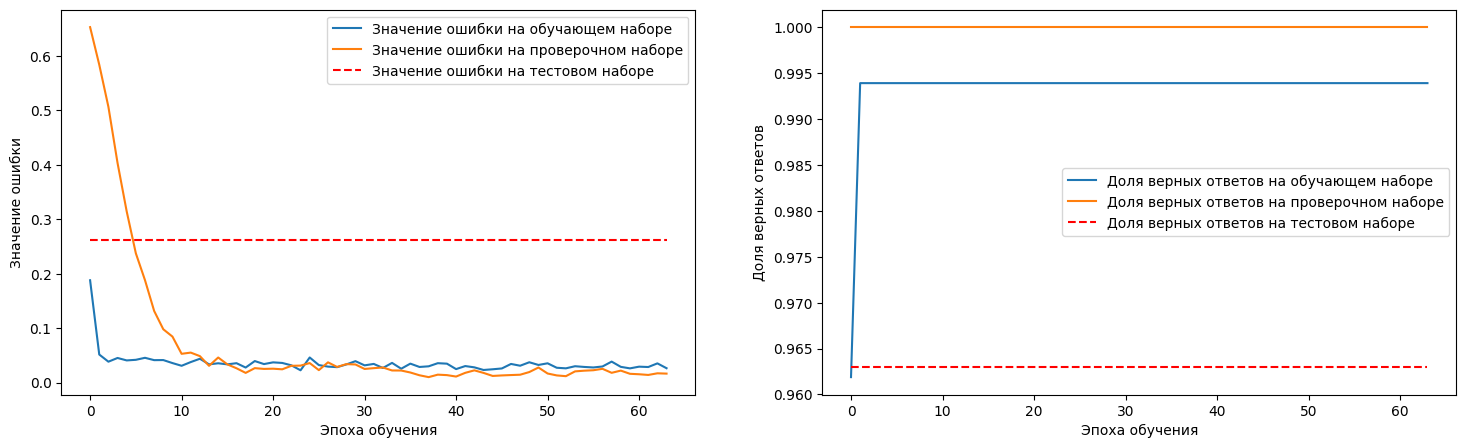

In [286]:
# Создание полотна для рисунка
plt.figure(1, figsize=(18, 5))

# Задание первой (левой) области для построения графиков
plt.subplot(1, 2, 1)
# Отрисовка графиков 'loss' и 'val_loss' из значений словаря store_learning.history
plt.plot(history.history['loss'],
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Значение ошибки на проверочном наборе')
plt.plot( [ scores[0] ] * len(history.history['loss']),
         label='Значение ошибки на тестовом наборе', linestyle='--', color='red')
# Задание подписей осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()

# Задание второй (правой) области для построения графиков
plt.subplot(1, 2, 2)
# Отрисовка графиков 'accuracy' и 'val_accuracy' из значений словаря store_learning.history
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.plot( [ scores[1] ] * len(history.history['accuracy']),
         label='Доля верных ответов на тестовом наборе', linestyle='--', color='red')
# Задание подписей осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()

# Фиксация графиков и рисование всей картинки
plt.show()

На графиках отображены значения ошибки и доля верных ответов для обучающего, проверочного и тестового наборов.

Исходя из данных, можно заключить, что, в целом, тотального переобучения нейросети удалось избежать. Пусть значение ошибки на тестовом наборе и далеко от нуля, но в результате экспериментов его удалось снизить до порядка 27%. Тем не менее, этот показатель всё ещё остаётся предельно значимым.

Что касается доли верных ответов, на лицо ситуация, когда при обучении и проверки их значение стремится к 1, в то время как на тестах точночть составляет 96.4%. Этот показатель соответствует заданным критерям ТЗ, однако не отражает реально положение вещей.

Подробнее см. _**"Заключение"**_.

## **Матрица ошибок**

In [287]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [292]:
y_pred = model.predict(x_test, verbose = 1)
y_pred = np.argmax(y_pred, axis=1)

y_pred

3/3 [==============================] - 0s 4ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [293]:
y_test.loc[y_test[1.0] == 1]

,0.0,0.5,1.0
1949,0,0,1
388,0,0,1


In [294]:
y_true = np.argmax(y_test.to_numpy(), axis=1)

y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [265]:
#y_true.rename(columns={0.0: 'Годен', 0.5: 'Огр. Годен', 1.0: 'Не годен'}, inplace=True)
#y_pred.rename(columns={0.0: 'Годен', 0.5: 'Огр. Годен', 1.0: 'Не годен'}, inplace=True)

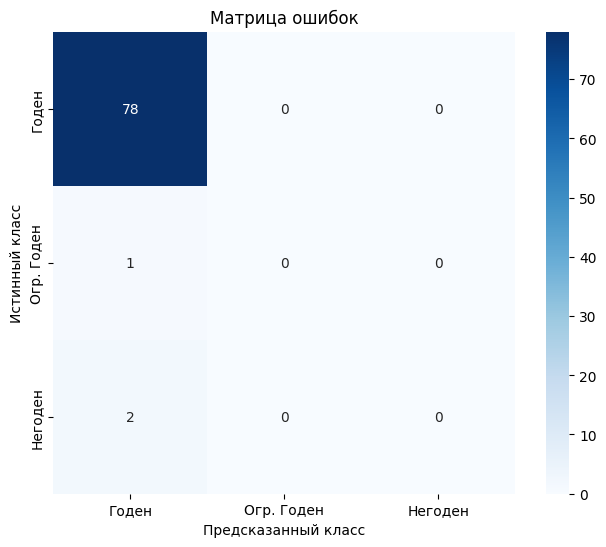

In [295]:
# Вычисление матрицы ошибок
conf_matrix = confusion_matrix(y_true, y_pred)

# Отрисовка матрицы ошибок с помощью seaborn и matplotlib
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', square=True,
            xticklabels=['Годен', 'Огр. Годен', 'Негоден'],
            yticklabels=['Годен', 'Огр. Годен', 'Негоден'])
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок')
plt.show()

После радостных показаний прошлого раздела, именно Матрица Ошибок должна прояснить реально положение вещей.

Исходя из этих данных, можно понять, чем объясняется столь высокая доля верных ответов, появившаяся несмотря на всю критику _**"Промежуточных выводов"**_.

Можно заметить, что модель не сделала ни одного предсказания, кроме "Годен", что привело к формированию ложной видимости её обученности. В реальности же, нейросеть просто выдаёт ответ "Годен", угадывая в 78 из 81 случаях ввиду расбалансировки датасета, что и приводит к формированию точночти в 95+%.

# Заключение

---

Подведём общие итоги проделанной работы.

Все ключевые моменты уже были отражены в соответсвующих разделах с выводами, а потому агломирируем их в краткий самап.

1. В ходе подготовительного этапа проекта - НИРа по исследованию ДС - были сделаны выводы о невалидности предоставленного датасета. Основными тезисами стали:

  * Скудная заполненность
  * Жуткая разбалансировка

  Кроме данных тезисов, результатом НИРа стал обрезанный датасет, сохранивший наибольшее число записей, доступных для обучения, но потерявший значительное количество колонок.

2. Вторым этапом проекта стала Практическая Реализация и Проверка Гипотез. Результатом работа стала обученная модель, готовая к эксплуатации. Модель была проверена на тестовой выборке. Тесты показали объективность гипотез НИРа и подтвердили их, а именно:
  
  * В связи со скудной заполненностью датасета неизбежным становится переобучение модели. Все возможные методы: от изменения архитектуры НС до настройки гиперпараметров - позволяют снизить эффект переобучения, но ни один из них не позволяет в полной степени нивелировать его.
  * Расбалансировка датасета, примитивно выражаясь, приводит модель к выводу о том, что выдавая результат "ГОДЕН", она практически каждый раз угадает ответ. Этот феномен приводит к поглащению прочих предполагаемых выводы выводом "ГОДЕН", что, в свою очередь, так же ложно формирует показатель точности в 95+%. Данный материал наглядно отражён тепловой картой матрицы ошибок соответсвующего раздела.

Заключением проделанной работы является вывод (выведенный теоретически и подкреплённый практическим примером) о том, что предоставленный датасет плох и не подходит для решения поставленной задачи.